In [1]:
import sys
sys.path.append("../")
import numpy as np
import phate
import graphtools as gt
import numpy as np
import pygsp
from src.mds import embed_MDS
import scprep
from scipy.spatial.distance import jensenshannon
from src.embedding import EmbJSD, EmbHeatGeo, EmbHeatPHATE, EmbCTD, EmbGraphMMD, EmbDer, EmbMarHeatGeo
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from src.cheb import expm_multiply
import networkx as nx
import random

from src.hyperbolic.treerep import treerep
from src.hyperbolic.sarkar import sarkar_embedding
from src.hyperbolic.multiprecision import poincare_dist
from src.hyperbolic.pehr import HierarchicalEmbeddings

2023-02-08 15:23:58.525881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 15:23:59.999303: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-08 15:24:00.103323: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-08 15:24:00.103421: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
data, labels = phate.tree.gen_dla(n_branch=5, branch_length=500)
knn=5
anisotropy=0
decay=40
tau=20

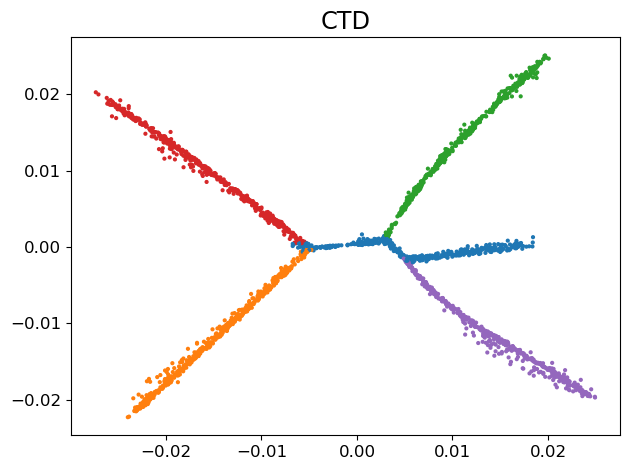

In [3]:
emb_op = EmbCTD(knn=knn)
emb_op.scatterplot(data,labels,title="CTD")

In [101]:
random.seed(42)
l = random.sample(list(range(len(labels))),len(labels))
M = []
for i in l:
    Mi = np.array([emb_op.dist[i, v] for v in l]) #pick the probabilities that x condition on m-many mu points, shape m * m
    M.append(Mi)
M = np.array(M)
M = M.round(decimals=4)

labels = [labels[v] for v in l]
labels = {i: m for i, m in enumerate(labels)}


tree_phate = treerep(M, return_networkx=True)

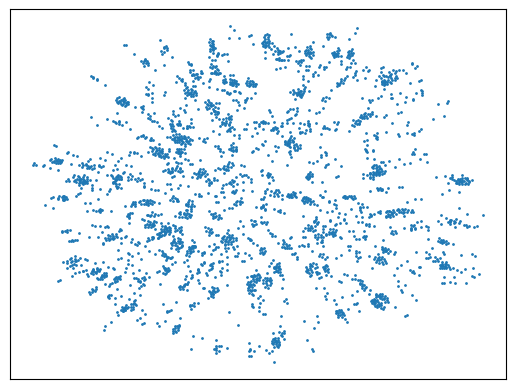

In [34]:
nx.draw_networkx_nodes(tree_phate,pos=nx.spring_layout(tree_phate), node_size = 1)

In [109]:
import torch
root = 2 # label of root node
tau = 1.5 # scaling factor for edges
embed_2D = sarkar_embedding(tree_phate, root, tau=tau)

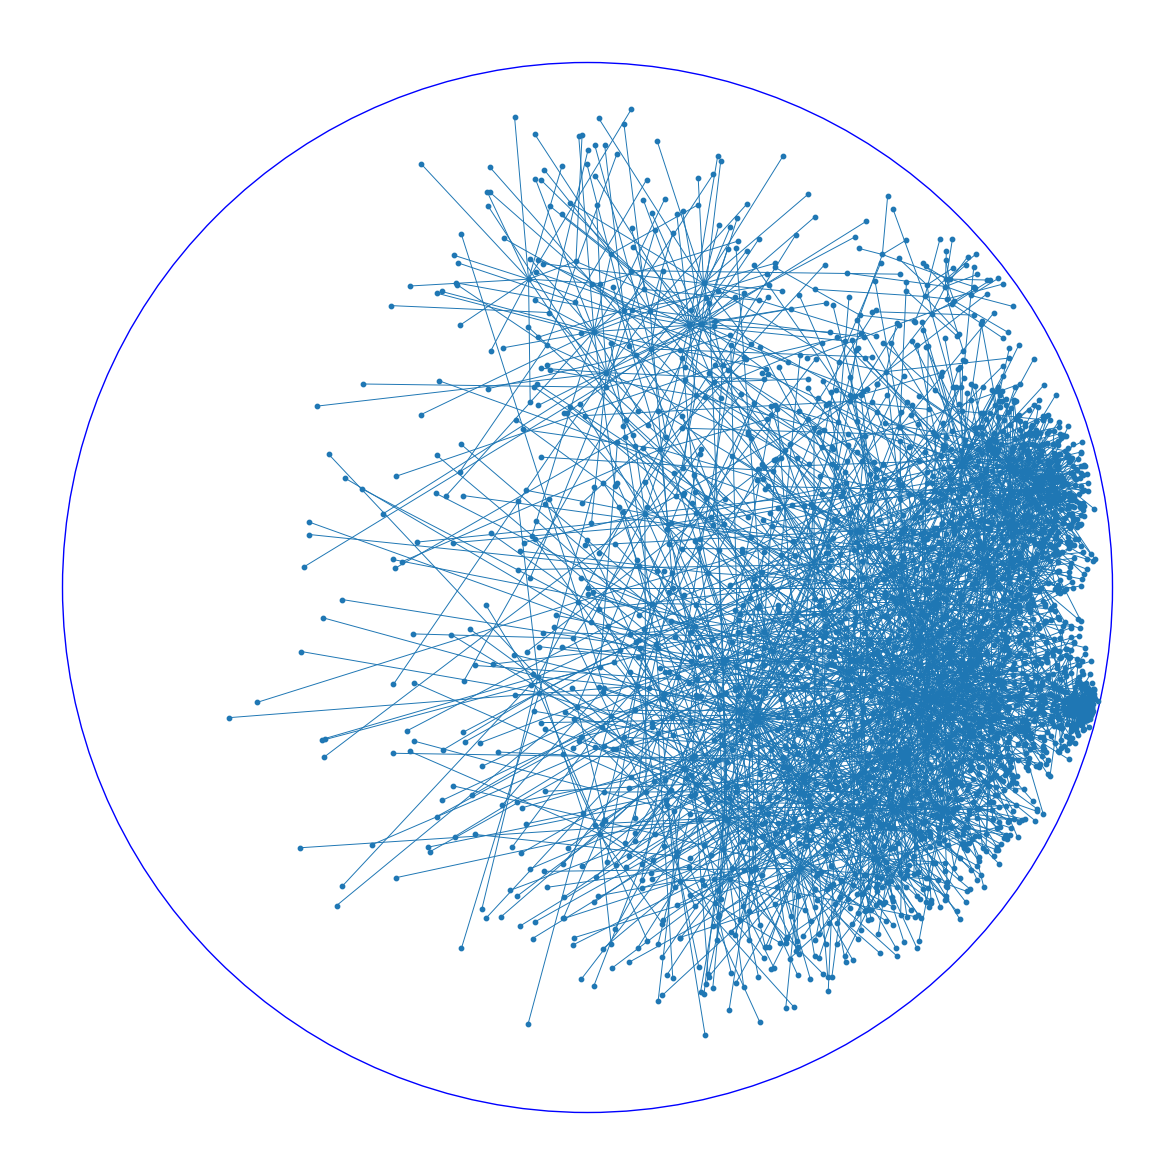

In [110]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_embedding(G, embedding, **kwargs):
    pts = np.array(list(map(float, embedding))).reshape(-1,2)
    size = kwargs.get("figsize", (15,15))
    plt.figure(figsize=size)
    labels = kwargs.get("labels", None)
    #if labels:
        #for i in labels:
            #plt.annotate(labels[i], pts[i],size=14, bbox=dict(facecolor='grey',alpha=0.1))
    lines = [(pts[e[0]],pts[e[1]]) for e in G.edges]
    lc = LineCollection(lines,linewidths=0.7)
    circle = plt.Circle((0, 0), 1, fill=False, color="b")
    plt.gca().add_artist(circle)
    plt.gca().set_aspect("equal")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    size = kwargs.get("node_size", 10)
    plt.scatter(pts[:,0],pts[:,1], s=size)
    plt.gca().add_collection(lc)
    plt.axis("off")
    plt.show()

plot_embedding(tree_phate, embed_2D, labels=labels)